In [1]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
tf.__version__

'1.15.3'

In [4]:
dataset, metadata = tfds.load('fashion_MNIST', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [27]:
[x for x in dir(metadata) if not x.startswith('_')]

['as_json',
 'as_proto',
 'citation',
 'compute_dynamic_properties',
 'data_dir',
 'dataset_size',
 'description',
 'download_size',
 'features',
 'full_name',
 'homepage',
 'initialize_from_bucket',
 'initialized',
 'metadata',
 'name',
 'read_from_directory',
 'redistribution_info',
 'splits',
 'supervised_keys',
 'update_splits_if_different',
 'version',
 'write_to_directory']

In [28]:
[x for x in dir(metadata.splits) if not x.startswith('_')]

['add',
 'clear',
 'copy',
 'from_proto',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'to_proto',
 'total_num_examples',
 'update',
 'values']

In [6]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of Training Examples:", num_train_examples)
print("Number of Testing Examples:", num_test_examples)

Number of Training Examples: 60000
Number of Testing Examples: 10000


In [7]:
# preprocess - normalize the image data from [0,255] to [0,1]
def normalize(images, labels):
    # cast to float
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

# apply normalize function to entire dataset
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# cache images after loading from disk for faster training
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])


In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [11]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 1875 steps
Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.6716 - accuracy: 0.7994
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.6193 - accuracy: 0.8441
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.6069 - accuracy: 0.8557
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5979 - accuracy: 0.8641
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5941 - accuracy: 0.8676
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5905 - accuracy: 0.8712
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5847 - accuracy: 0.8769
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5815 - accuracy: 0.8807
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5782 - accuracy: 0.8838
Epoch 10/10
1875/1875 [==============================] - 4s 2

In [12]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 1.5933 - accuracy: 0.8687
Accuracy on test dataset: 0.8687


In [13]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [14]:
predictions.shape

(32, 10)

In [15]:
predictions[0]

array([2.8146807e-27, 7.0252401e-21, 2.3818238e-15, 9.6349894e-20,
       1.0000000e+00, 2.2557703e-23, 1.7902343e-10, 7.8821888e-30,
       3.7586164e-15, 1.9938375e-27], dtype=float32)

In [16]:
np.argmax(predictions[0])

4

In [17]:
print(test_labels[0])
print(class_names[4])

4
Coat


In [18]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[...,0], cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)
    
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    graph = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    graph[predicted_label].set_color('red')
    graph[true_label].set_color('blue')

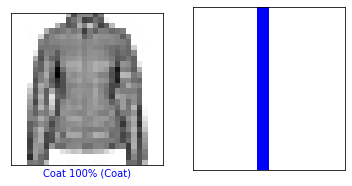

In [19]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

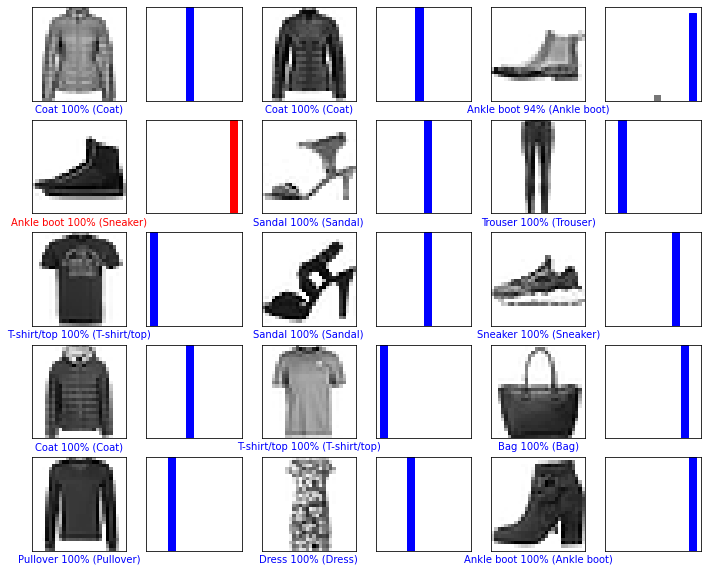

In [20]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)


In [21]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [22]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [23]:
predictions_single = model.predict(img)

print(predictions_single)

[[2.8146807e-27 7.0252401e-21 2.3818147e-15 9.6349894e-20 1.0000000e+00
  2.2557618e-23 1.7902275e-10 7.8821888e-30 3.7586164e-15 1.9938300e-27]]


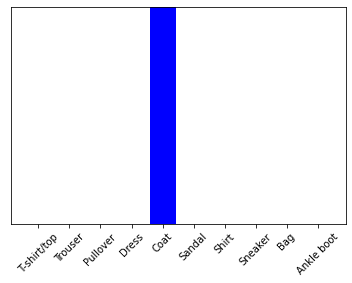

In [24]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [25]:
class_names[np.argmax(predictions_single[0])]

'Coat'